In [ ]:
!pip install ray
!pip install pytorch_lightning
!pip install darts

In [3]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts.models import TiDEModel
from darts import TimeSeries

Load Data / Spilt Data

In [6]:
df = pd.read_csv('/content/EDvisitfile.csv')

series = TimeSeries.from_dataframe(df, 'date', 'No')
train_scaler = Scaler()
series_scaled = train_scaler.fit_transform(series)

#Spilt data
train_proportion = 0.5
val_proportion = 0.4

# Calculate the split indices
train_end = int(len(series) * train_proportion)
val_end = train_end + int(len(series) * val_proportion)

# Split the list
train = series[:train_end]
val = series[train_end:val_end]
test = series[val_end:]

Hypertuning

In [7]:
# Create the model using model_args from Ray Tune
def train_model(model_args, callbacks, train, val):
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])
    model = TiDEModel(
        input_chunk_length=720,
        output_chunk_length=48,
        n_epochs=50,
        torch_metrics=torch_metrics,
        pl_trainer_kwargs={"callbacks": callbacks, "enable_progress_bar": False},
        **model_args)
    model.fit(
        series=train,
        val_series=val,
    )

In [5]:
# define the hyperparameter space
config = {
    'hidden_size': tune.choice([256, 512, 1024]),
    'temporal_decoder_hidden': tune.choice([8, 16, 32]),
    "num_encoder_layers": tune.choice([1, 2, 3]),
    "num_decoder_layers": tune.choice([1, 2, 3]),
    "dropout": tune.uniform(0, 0.1),
}

my_stopper = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",
    patience=5,
    min_delta=0.05,
    mode='min',
)

In [13]:
# set up ray tune callback
tune_callback = TuneReportCallback(
    {
        "loss": "val_loss",
        "MAPE": "val_MeanAbsolutePercentageError",
    },
    on="validation_end",
)

# earlystopping
my_stopper = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",
    patience=5,
    min_delta=0.05,
    mode='min',
)

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "MAPE", "training_iteration"],
)

In [ ]:
# Run Ray Tune, optimize hyperparameters by minimizing the MAPE on the validation set
num_samples = 15

scheduler = ASHAScheduler(max_t=1000, grace_period=3, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(
    train_model, callbacks=[my_stopper, tune_callback], train=train, val=val,
)

analysis = tune.run(
    train_fn_with_parameters,
    #resources_per_trial=resources_per_trial,
    # Using a metric instead of loss allows for
    # comparison between different likelihood or loss functions.
    metric="MAPE",  # any value in TuneReportCallback.
    mode="min",
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_darts",
)

print("Best hyperparameters found were: ", analysis.best_config)

After get optimal hyperparameter, train fine model

In [ ]:
!pip install torch

In [16]:
import torch

In [103]:
'''
optimizer_kwargs = {
    "lr": 0.001,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 150,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 5,
    "min_delta": 1,
    "mode": "min",
}


common_model_args = {
    "input_chunk_length": 720,  # lookback window
    "output_chunk_length": 48,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "force_reset": True,
    "batch_size": 32,
    "random_state": 42,}
'''
# 帶入ray tune選出的hyperparameter, 並調整其他hyperparameter
model_TiDE = TiDEModel(
    input_chunk_length=1080,
    output_chunk_length=40,
    num_encoder_layers=3,
    num_decoder_layers=1,
    decoder_output_dim=32,
    hidden_size=256,
    temporal_decoder_hidden=32,
    use_layer_norm=True,
    dropout=0.08,
    random_state=42,
    batch_size=32,
    optimizer_kwargs = {
    "lr": 0.001,},
    pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 400,
    "accelerator": "auto",
    "callbacks": [],},
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR,
    lr_scheduler_kwargs = {
    "gamma": 0.999},
    model_name="TiDE14",  #每次改變model_name以儲存weight

    save_checkpoints='/content/darts_logs/_model.pth.tar',)

models = {
    "TiDE": model_TiDE,
}

In [104]:
# Run fine tuned hyperparameter
for name, model in models.items():

    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    model.fit(
        series=train,
        val_series=val,
        verbose=False,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [106]:
#取出表現最好的weight
model_TiDE.load_weights_from_checkpoint('TiDE14')

Make prediction

In [80]:
from darts.metrics import mae, mse, mape
import matplotlib.pyplot as plt

In [107]:
Model_prediction = model.predict(len(series)-len(train))
Model_prediction_val, Model_prediction_test = Model_prediction.split_before(0.75)
Model_mae = mae(test, Model_prediction)
Model_mse = mse(test, Model_prediction)
Model_mape = mape(test, Model_prediction)

print(Model_mae, Model_mse, Model_mape)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

41.93722622734266 2731.3604763879066 8.983598513456418


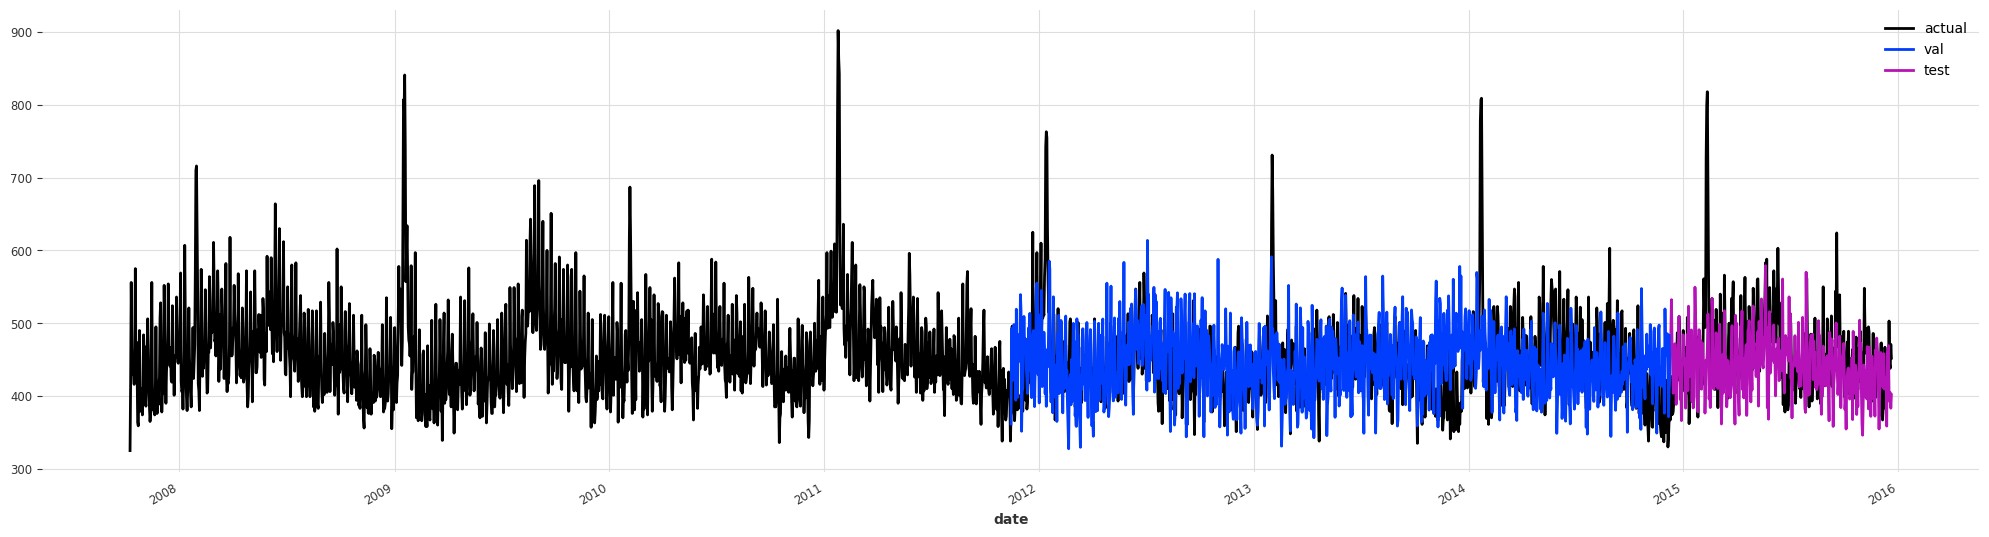

In [108]:
plt.figure(figsize=(25, 6))
series.plot(label='actual')
Model_prediction_val.plot(label='val')
Model_prediction_test.plot(label='test')
#TiDEModel_prediction.plot(label='forecast', lw=1)

plt.legend()
plt.show()